In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm


**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 06: Redes neurais

**1.** O código abaixo baixa e carrega o banco de dados _CIFAR10_, que contém diversas imagens RGB de **10 classes distintas**. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação.

Também provemos um exemplo de como definir um modelo em _PyTorch_ (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. **Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação.**

Consulte a documentação do _PyTorch_ para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado.

Além disso, mostre como os dados de entrada são transformados ao longo das camadas (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

cpu
Files already downloaded and verified
Files already downloaded and verified


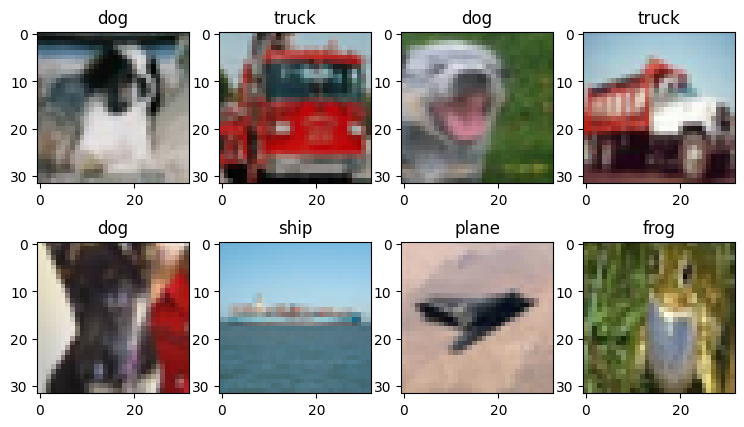

In [83]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
batch_size = 2048

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

#definindo conjunto de validação
trains_set, validation_set = random_split(train_set, [0.75, 0.25])

validation_loader = DataLoader(
    validation_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i]/2 + 0.5
    npimg = npimg.numpy()
    ax[i%2,i//2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i%2,i//2].set_title(classes[labels[i]])



Inicialmente, gostaria de destacar que criei acima também o conjunto de validação para ser usado mais abaixo. Na célula abaixo, estou criando uma classe chamada CNN para construir uma rede neural convolucional (CNN) para classificação de imagens. Minha CNN possui duas camadas convolucionais, seguidas por camadas de pooling, e duas camadas totalmente conectadas. Estou treinando a CNN usando o otimizador Adam e a função de perda de entropia cruzada ao longo de 10 épocas. Calculo a acurácia do modelo nos dados de teste e também o erro de validação usando a função e \textit{rrorValidation}.

In [84]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.001)


for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    aux = 0
    for data in train_loader:
        if aux == 0 and epoch == 0:
            print('this is how to load a training batch')
        aux += 1
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_cnn.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

def acuracia(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

print('Accuracy of the network: %d %%' % (100*acuracia(test_loader)))

def errorValidation(loader):
    critery = nn.CrossEntropyLoss()
    loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = cnn(images)
            loss += critery(outputs, labels).item()
    return loss/len(loader)

print('Error of the network: %d %%' % errorValidation(test_loader))

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


this is how to load a training batch
Accuracy of the network: 48 %
Error of the network: 1 %


Agora, defino uma nova classe, variante da classe definida acima, onde variamos os hiperparâmetros e encontrarmos o melhor conjunto de hiperparâmetros em relação ao erro de validação.

In [85]:
class VariantCNN(nn.Module):
    def __init__(self, outChannels1, outChannels2, kernelSize, poolKernelSize, poolStride, outSizeLazy, outSizeLinear2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, outChannels1, kernelSize)
        self.pool = nn.MaxPool2d(poolKernelSize, poolStride)
        self.conv2 = nn.Conv2d(outChannels1, outChannels2, kernelSize)
        self.fc1 = nn.LazyLinear(outSizeLazy)
        self.fc2 = nn.Linear(outSizeLazy, outSizeLinear2)
        self.fc3 = nn.Linear(outSizeLinear2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def accuracy(self):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct/total

    def errorValidation(self):
        criterion = nn.CrossEntropyLoss()
        loss = 0
        with torch.no_grad():
            for data in validation_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = self(inputs)
                loss += criterion(outputs, labels).item()
        return loss/len(validation_loader)


Por questão de desempenho do computador e tempo, vamos permitir que apenas alguns hiperparâmetros variem. Abaixo, limito a quantidade de combinações em 8, variando 3 hiperparâmetros apenas entre dois valores. 

In [93]:
# outChannels1s = [3, 6]
# outChannels2 = [16, 35]
# outSizesLazy = [5]
# outSizesLinear2 = [2, 85]
# kernelSizes = [5]
# poolKernelSizes = [2, 120] 
# poolStrides = [84]
# definimos listas com dois valores possiveis para cada hiperparametro
outChannels1s = [6]
outChannels2 = [16, 32]
outSizesLazy = [120]
outSizesLinear2 = [84]
kernelSizes = [5]
poolKernelSizes = [2, 3]
poolStrides = [2, 3]
# writes each combination, accuracy and validation error in a file
with open('results.csv', 'w') as f:
    # add header to file
    f.write('outChannel1,outChannel2,kernelSize,poolKernelSize,poolStride,outSizeLazy,outSizeLinear2,error\n')
    for outChannel1 in outChannels1s:
            for outChannel2 in outChannels2:
                for outSizeLazy in outSizesLazy:
                    for outSizeLinear2 in outSizesLinear2:
                        for kernelSize in kernelSizes:
                            for poolStride in poolStrides:
                                for poolKernelSize in poolKernelSizes:
                                    variantCNN = VariantCNN(outChannel1, outChannel2, kernelSize, poolKernelSize, poolStride, outSizeLazy, outSizeLinear2).to(device)  
                                    criterion = nn.CrossEntropyLoss()
                                    optimizer_variantCNN = torch.optim.Adam(variantCNN.parameters(), lr=0.001)
                                    for epoch in range(5):
                                        for data in train_loader:
                                            inputs, labels = data[0].to(device), data[1].to(device)
                                            optimizer_variantCNN.zero_grad()
                                            outputs = variantCNN(inputs)
                                            loss = criterion(outputs, labels)
                                            loss.backward()
                                            optimizer_variantCNN.step()
                                    error = variantCNN.errorValidation()
                                    print(f'Loss: {error}')
                                    f.write(str(outChannel1) + ',' + str(outChannel2) + ',' + str(kernelSize) + ',' + str(poolKernelSize) + ',' + str(poolStride) + ',' + str(outSizeLazy) + ',' + str(outSizeLinear2) + ',' + str(error) + '\n')

Loss: 1.559175763811384
Loss: 1.6004787342888969
Loss: 1.710235595703125
Loss: 1.7004891974585397
Loss: 1.494153448513576
Loss: 1.5869430814470564
Loss: 1.6016590765544347
Loss: 1.6877800226211548


Agora, vamos extrair a melhor combinação de hiperparâmetros e treinar a CNN com esses hiperparâmetros. 

In [94]:
import pandas as pd
results = pd.read_csv('results.csv')
# get the row with the lowest error
melhor = results.loc[results['error'].idxmin()]
print('Best combination:\n',melhor)

Best combination:
 outChannel1         6.000000
outChannel2        32.000000
kernelSize          5.000000
poolKernelSize      2.000000
poolStride          2.000000
outSizeLazy       120.000000
outSizeLinear2     84.000000
error               1.494153
Name: 4, dtype: float64


c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


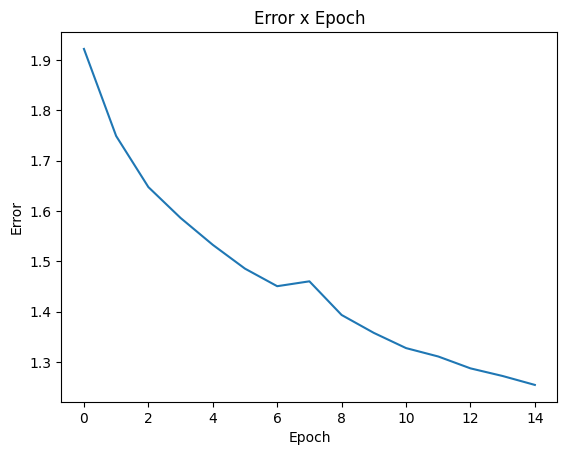

Acurácia: 0.3867


In [95]:

listBest = melhor.tolist()
outChannel1 = int(listBest[0])
outChannel2 = int(listBest[1])
kernelSize = int(listBest[2])
poolKernelSize = int(listBest[3])
poolStride = int(listBest[4])
outSizeLazy = int(listBest[5])
outSizeLinear2 = int(listBest[6])
#treinar a rede com o melhor modelo
bestCNN = VariantCNN(outChannel1, outChannel2, kernelSize, poolKernelSize, poolStride, outSizeLazy, outSizeLinear2).to(device)                               
criterion = nn.CrossEntropyLoss()
optimizer_bestCNN = torch.optim.Adam(bestCNN.parameters(), lr=0.001)
losses = []
for epoch in range(15):
    loss_epoch = 0
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_bestCNN.zero_grad()
        outputs = bestCNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_bestCNN.step()
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = bestCNN(inputs)
        loss_epoch += criterion(outputs, labels).item()
    losses.append(loss_epoch/len(train_loader))
# print('Accuracy of the network: %d %%' % (100*bestCNN.accuracy(test_loader)))
# print('Error of the network: %d %%' % bestCNN.errorValidation(test_loader))

#plotar gráfico de erro
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error x Epoch')
plt.show()
print('Acurácia:', variantCNN.accuracy())

Para termos o resultado a cada camada podemos realisar ajustes na função forward da classe CNN.

In [96]:
class VariantCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, outChannel1, kernelSize)
        self.pool = nn.MaxPool2d(poolKernelSize, poolStride)
        self.conv2 = nn.Conv2d(outChannel1, outChannel2, kernelSize)
        self.fc1 = nn.LazyLinear(outSizeLazy)
        self.fc2 = nn.Linear(outSizeLazy, outSizeLinear2)
        self.fc3 = nn.Linear(outSizeLinear2, 10)

    # x is the input image, pics is a list with the images after each layer
    def forward(self, x):
        pics = []
        x = self.conv1(x)
        pics.append(x)
        x = self.pool(F.relu(x))
        pics.append(x)
        x = self.conv2(x)
        pics.append(x)
        x = self.pool(F.relu(x))
        pics.append(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        pics.append(x)
        x = F.relu(self.fc2(x))
        pics.append(x)
        x = self.fc3(x)
        pics.append(x)
        return x, pics

# train the model with the best combination
variantCNN = VariantCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_variantCNN = torch.optim.Adam(variantCNN.parameters(), lr=0.001)

for epoch in range(10):
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_variantCNN.zero_grad()
        outputs, pics = variantCNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_variantCNN.step()

Vamos plotar o resultado em alguma imagem pra visualizar o que a rede neural está aprendendo.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


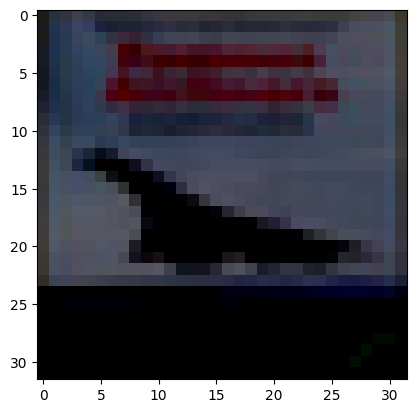

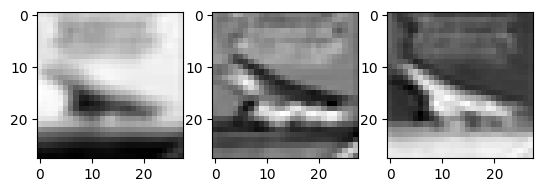

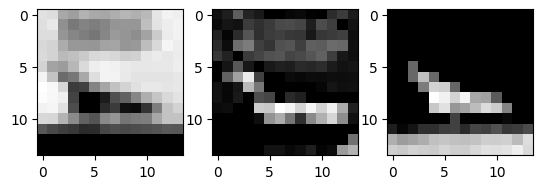

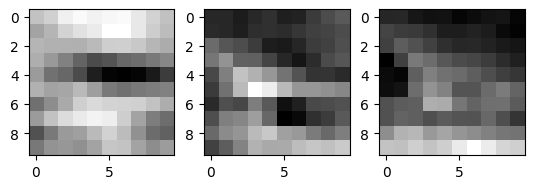

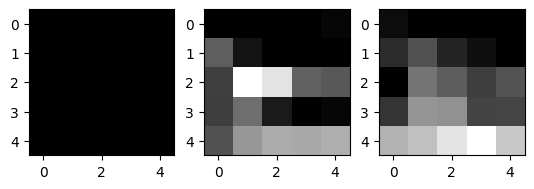

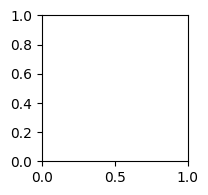

In [97]:
image_tensor = test_set[3][0]
image = image_tensor.unsqueeze(0)
image = image[0]/2 
image = np.transpose(image.numpy(), (1, 2, 0))
plt.imshow(image)
plt.show()

# gets the pics after each layer
_, pics = variantCNN(image_tensor.unsqueeze(0).to(device))

# plot the pics

for i, pics in enumerate(pics):
    try:
        # Verifique se ainda há imagens para plotar
            for j in range(3):
                plt.subplot(1, 3, j+1)
                plt.imshow(pics[0, j].cpu().detach().numpy(), cmap='gray')
            plt.show()
    except:
        pass


(não sei pq só essa  imagem $\uparrow$ saiu em branco)

Podemos ver que a rede neural está aprendendo a identificar as características de borda das imagens (primeira camada convolucional) e simplificando as imagens (camadas de pooling) para nós as etapas de pooling não são perceptíveis, mas necessárias pro desempenho da máquina.

# Exercício de "papel e caneta"

**1.** Na aula discutimos como CNNs podem ser vistas como casos especiais de MLPs. Com isso em mente, mostre que 
1) camadas convolucionais podem ser escritas como uma transformação linear seguida por uma transformação não linear; e 
2) camadas de pooling de média ou soma podem ser escritas como transformações lineares. 

Tendo a transformação linear (no caso bidimensional) dada por
$$S(i,j) = (X \star K)(i,j) = \sum_m\sum_n X(m,n)K(i-m,j-n)$$
em que $X$ é a imagem de entrada, $K$ é o kernel da convolução e $S$ é a saída da convolução. Estamos fazendo uma transformação linear pois estamos combinando as entradas de $X$ com os pesos de $K$. Nessa primeira etapa estamos essencialmente realizando uma operação de convolução fazendo um \textit{downsampling} da imagem de entrada.

A transformação não linear é dada pela função de ativação, que é aplicada a cada elemento da saída da convolução.Aqui,
$$z = \sigma(y)$$
A função mais comum é a função de ativação ReLU. Aplicamos essa função a cada elemento da saída da convolução.Daí, cada comada convulacional pode ser escrita como
$$z = \sigma(S(i,j))$$
Uma camada de pooling de média ou soma pode ser escrita como uma transformação linear. Seja $X$ a imagem de entrada e $Y$ a imagem de saída. A operação de pooling é dada por
$$y = Wx$$
onde $W$ é uma matriz de pesos e $x$ é a imagem de entrada. A operação de pooling é uma operação linear pois estamos combinando as entradas de $X$ com os pesos de $W$. Note que $W$ é um vetor de pesos com todos os elementos iguais a $1/n$, onde $n$ é o tamanho da janela de pooling. Quando a operação de pooling é de soma, $W$ é um vetor de pesos com todos os elementos iguais a $1$.

**2.** Criar modelos invariantes a transformações específicas das suas entradas é um tópico quente em machine learning. Por exemplo, suponha que queremos prever propriedades de um grafo $G$ de $n$ nós, com matriz de adjacência $A \in \{0,1\}^{n \times n}$ e em que cada nó $i=1,\ldots,n$ é anotado com um vetor de features $x_i \in \mathbb{R}^d$. Seja também $X = [x_1, \ldots, x_n]^\intercal$ a matriz de features dos nós.

Note também que um grafo com features de nó pode ser descrito como uma tupla $(X, A)$ sem perda de generalidade. Nesse caso, gostaríamos que nossa rede neural $f$ produzisse o mesmo output para grafos identicos (i.e., fosse invariante a isomorfismo). Dizemos que dois grafos $G=(X, A)$ e $G^\prime=(X^\prime, A^\prime)$ são isomorfos se existe uma matriz de permutação $P \in \{0,1\}^{n \times n} : \forall_i \sum_i P_{ij} = 1, \forall_j \sum_j P_{ij} = 1 $ tal que $X^\prime = P X$ e $A^\prime = P A P^\intercal$.

Existe uma classe de redes neurais desenhadas especialmente para serem invariantes a isomorfismo: _graph neural networks_ (GNNs). A mais famosa dessas redes é chamada [_graph convolutional network_ (GCN)](https://arxiv.org/abs/1609.02907). O funcionamento de uma GCN de $L$ camadas para classificação de propriedades de grafos pode ser descrito como:
\begin{align}
&\hat{y} = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{(L)}_{i:}\right)\\
&H^{(\ell)} = \textrm{ReLU}(\tilde{A}H^{(\ell-1)} W^{(\ell)}) \qquad \forall \ell=1,\ldots,L\\
&H^{(0)} = X
\end{align}
onde $W^{(\ell)} \in \mathbb{R^{d_{\ell-1} \times d_{\ell}}}$ são matrizes de peso, com $d_0 = d$ e $d_L$ sendo o número de classes do nosso problema de classificação. Além disso, $\tilde{A} = D^{-1/2}(A + I)D^{-1/2}$ onde $D$ é uma matriz diagonal com $D_{ii}$ contendo o grau do nó $i$.

**Prove que a GCN descrita acima produz o mesmo valor para qualquer grafo isomorfo a $G=(X, A)$.**

Se você estiver interessado em aprender o básico sobre GNNs, esse vídeo é um bom começo: https://www.youtube.com/watch?v=8owQBFAHw7E (não é necessário para resolver essa questão).

(Dica: Mostre antes que se $P$ é uma matriz de permutação, então $P^\intercal P = I$.)

Vamos mostrar que $P^TP = I$. Como $P$ é uma matriz de permutação, então $P_{ij} \in \{0,1\}$. $P^T$ também é uma matriz de permutação. O que $P$ faz é permutar a linha $j$ para a linha $i$. $P^T$ faz o oposto, permuta a linha $i$ para a linha $j$. Se $P_{ij} = 1$, então $P^T_{ji} = 1$. Se $P_{ij} = 0$, então $P^T_{ji} = 0$. Se $i \neq j$, então $P_{ij} = 0$ e $P_{ji} = 0$. Então, $P^TP = I$.
Vamos definir um grfo isomorfo como $G^\prime = (X^\prime, A^\prime)$, onde $X^\prime = PX$ e $A^\prime = PAP^T$. Escrevendo o output da GCN para $G$ e $G^\prime$:
$$\hat{y}^\prime = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{(L)}_{i:}\right)$$

$$H^{\prime(\ell)} = \textrm{ReLU}(\tilde{A}^\prime H^{(\ell-1)} W^{(\ell)}) \qquad \forall \ell=1,\ldots,L$$

$$H^{\prime(0)} = X\prime = PX$$

Vamos desenvolver $\tilde{A}^\prime$:

$$\tilde{A}^\prime = PD^{-1/2}P^TPAP^TPD^{-1/2}P^T + PD^{-1/2}P^TPD^{-1/2}P^T$$

$$\tilde{A}^\prime = PD^{-1/2}AD^{-1/2}P^T + PD^{-1/2}D^{-1/2}P^T$$

$$\tilde{A}^\prime = PD^{-1/2}(A+I)D^{-1/2}P^T$$

$$\tilde{A}^\prime = P\tilde{A}P^T$$

Agora substituindo $\tilde{A}^\prime$ na equação de $H^{\prime(\ell)}$:

$$H^{\prime(\ell)} = \textrm{ReLU}(P\tilde{A}P^TH^{(\ell-1)}W^{(\ell)})$$

Vamos analisar o que ocorre na próxim iteração:

$$H^{\prime(l)} = \textrm{ReLU}(P\tilde{A}P^TH^{(0)}W^{(1)})$$

$$H^{\prime(l)} = \textrm{ReLU}(P\tilde{A}P^TPXW^{(1)})$$

$$H^{\prime(l)} = \textrm{ReLU}(P\tilde{A}XW^{(1)})$$

$$H^{\prime(l)} = PH^{(1)}$$

Como esse processo se repete em todas as camadas então $H^{\prime(L)} = PH^{(L)}$. Substituindo na equação do output:

$$\hat{y}^\prime = \textrm{Softmax}\left(\frac{1}{n} \sum_{i=1}^n H^{\prime(L)}_{i:}\right)$$

como $H^{\prime(L)} = PH^{(L)}$, então a soma de $H^{\prime(L)}$ é a mesma que a soma de $PH^{(L)}$. Portanto, $\hat{y} = \hat{y}^\prime$.